In [17]:
import os
import sys
import cv2
import torch
import requests
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from config import(
    DIRECTORY_MODEL, 
    DETECTION_MODEL,
    CLASSES_DETECTION,
    CLASSES_FILTERED
)

In [134]:
class SealDetection:
    '''
    Load custom model YoloV5
    for detection seal container number
    '''
    def __init__(self, model_name):
        self.model_name = model_name
        self.device     = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_path = os.path.join(DIRECTORY_MODEL, DETECTION_MODEL[self.model_name]['filename'])
        self.__check_model()
        self.model      = self.__load_model(self.model_path)
        

    @staticmethod
    def __load_model(model_path):
        try: model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
        except: sys.exit('Error load model')
        return model
            
    def __check_model(self):
        '''
        Checking model in model_path
        download model if file not found
        '''
        Path(DIRECTORY_MODEL).mkdir(parents=True, exist_ok=True)
        if not os.path.isfile(self.model_path):
            print(f'Downloading {self.model_name} detection model, please wait.')
            response = requests.get(DETECTION_MODEL[self.model_name]['url'], stream=True)
            
            progress = tqdm(response.iter_content(1024), 
                        f'Downloading {DETECTION_MODEL[self.model_name]["filename"]}', 
                        total=DETECTION_MODEL[self.model_name]['file_size'], unit='B', 
                        unit_scale=True, unit_divisor=1024)
            with open(self.model_path, 'wb') as f:
                for data in progress:
                    f.write(data)
                    progress.update(len(data))
                print(f'Done downloaded {DETECTION_MODEL[self.model_name]["filename"]} detection model.')
        else:
            print(f'Load {DETECTION_MODEL[self.model_name]["filename"]} detection model.')

    @staticmethod
    def extract_result(results, min_confidence=0.0):
        '''
        Format result([tensor([[151.13147, 407.76913, 245.91382, 454.27802,   0.89075,   0.00000]])])
        Filter min confidence prediction and classes id/name
        Cropped image and get index max value confidence lavel
        Args:
            result(models.common.Detections): result detection YoloV5
            min_confidence(float): minimal confidence detection in range 0-1
        Return:
            result(dict): {
                casess:[{
                    confidence(float): confidence,
                    bbox(list) : [x_min, y_min, x_max, y_max]
                }]
            }
        '''
        results_format  = results.xyxy
        results_filter =  dict({i:list() for i in CLASSES_FILTERED})
        
        if len(results_format[0]) >= 1:
            for i in range(len(results_format[0])):
                classes_name    = CLASSES_DETECTION[int(results_format[0][i][-1])]
                confidence      = float(results_format[0][i][-2])
                # print(classes_name, confidence)
                if classes_name in CLASSES_FILTERED and confidence >= min_confidence:
                    x_min, y_min = int(results_format[0][i][0]), int(results_format[0][i][1])
                    x_max, y_max = int(results_format[0][i][2]), int(results_format[0][i][3])
                    results_filter[classes_name].append(
                        {'confidence': round(confidence,2), 
                        'bbox':[x_min, y_min, x_max, y_max]}
                    )
        # Delete key if detection null
        for i in CLASSES_FILTERED:results_filter.__delitem__(i) if not results_filter[i] else None

        return results_filter
    
    def detection(self, image, size=320):
        '''
        Prediction image object detectionn YoloV5
        Args:
            image(numpy.ndarray) : image/frame
        Return:
            results_prediction(models.common.Detections) : results -> convert to (results.xyxy/resultsxywh)
        '''
        results = self.model(image, size=size)
        return results

In [135]:

class MainProcess:
    '''
        Main process seal detection
    '''
    def __init__(self):
        self.seal_detection = SealDetection('seal_detection')

    def __detection(self, image, size, threshold):
        '''
            Detection object
            Args:
                image(np.array) : image for detection
                size(int)       : size image detection
                threshold(float): min confidence
            Return:
                result(dict): {
                casess:[{
                    confidence(float): confidence,
                    bbox(list) : [x_min, y_min, x_max, y_max]
                }]
            }
        '''
        results = self.seal_detection.\
                detection(image=image, size=size)
        result  = self.seal_detection.\
                extract_result(results=results, min_confidence=threshold)
        return result
        
    def main(self, image, size, threshold):
        # Detection seal
        result = self.__detection(image, size=size, threshold=threshold)
        if not result: print(f'Seal not found'); return list()
        else: print('Seal Found')
        print(result)
        # Extract result to list
        result_list = [[[x['bbox'], key,  x['confidence']] for x in value]\
                      for key, value in result.items()][0]

        return result_list

In [99]:
def draw_rectangle_list(image, result_list, resize=100):
    '''
    Draw bounding box, label and clases detection image
    Args:
        img(numpy.ndarray) : image/frame
        result(list) : [[x_min, y_min, x_max, y_max, classes_name, confidence]]
    return : 
        image(numpy.ndarray)
    '''
    if len(result_list):
        for i in result_list:
            x_min, x_max = i[0][0], i[0][2]
            y_min, y_max = i[0][1], i[0][3]
            classes_name = i[1]
            confidence   = int(i[2]*100)
            color 		 = (255, 0, 0)
            # Draw rectangle
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 3)
            # Add label
            cv2.rectangle(image, (x_min, y_min-50), (x_min+300, y_min), color, cv2.FILLED)
            cv2.putText(image, f'{classes_name} found'.upper(), (x_min-2,y_min-12), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 3)

    width   = int(image.shape[1] * resize / 100)
    height  = int(image.shape[0] * resize / 100)
    # resize image
    resized = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
    return resized

In [136]:
process = MainProcess()

Load seal_detection.pt detection model.


Using cache found in /home/smartcam/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-9-22 torch 1.8.0 CUDA:0 (NVIDIA Tegra X1, 3964.125MB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients
Adding AutoShape... 


Seal Found
{'seal': [{'confidence': 0.94, 'bbox': [2100, 2504, 2181, 2721]}, {'confidence': 0.93, 'bbox': [2242, 2207, 2320, 2402]}]}


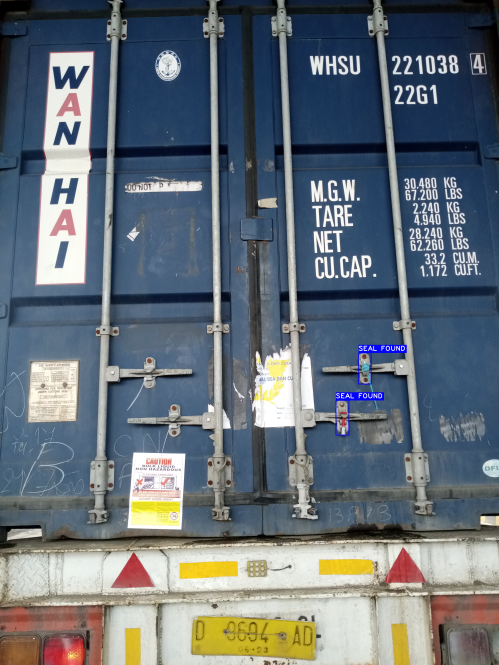

In [158]:
image   = cv2.imread('./images/IMG_20220223_102020_908.jpg')
results = process.main(image, size=480, threshold=0.75)
drawed  = draw_rectangle_list(image, results, resize=16)

Image.fromarray(cv2.cvtColor(drawed, cv2.COLOR_BGR2RGB))

In [22]:
from PIL import Image

In [ ]:
result = {'seal': [{'confidence': 0.93, 'bbox': [2324, 2400, 2009, 2197]}, {'confidence': 0.85, 'bbox': [2424, 2511, 2302, 2514]}]}

result_list = [[[x['bbox'], key,  x['confidence']] for x in value]\
                      for key, value in result.items()][0]
result_list